### Paketler

In [1]:
import os
import torch
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from functools import partial
from typing import Tuple, Union
import matplotlib.pyplot as plt 
from scikeras.wrappers import KerasRegressor
import optuna.visualization as vis
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

tf.random.set_seed(2002)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Veriyi Tanımlama

In [2]:
healthexp = sns.load_dataset("healthexp")
healthexp.info()
healthexp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             274 non-null    int64  
 1   Country          274 non-null    object 
 2   Spending_USD     274 non-null    float64
 3   Life_Expectancy  274 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 8.7+ KB


,Year,Country,Spending_USD,Life_Expectancy
0,1970,Germany,252.311,70.6
1,1970,France,192.143,72.2
2,1970,Great Britain,123.993,71.9
3,1970,Japan,150.437,72.0
4,1970,USA,326.961,70.9


Gösterilen veri kümesi, 1970 yılı için çeşitli ülkelerdeki sağlık harcamaları ve yaşam beklentisi verilerini içermektedir. Dört sütun içermektedir: 'Year', 'Country', 'Spending_USD' ve 'Life_Expectancy', sırasıyla tamsayı, dize ve kayan noktalı sayı veri tipleri. Eksik değer içermeyen 274 girdiden oluşan ve yaklaşık 8,7 KB bellek kaplayan bu Veri, sağlık harcamaları ile yaşam beklentisi arasındaki ilişkiyi araştıran analizler için uygundur.

####    Outlier'ları ayrıştırma

In [3]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


healthexp = remove_outliers(healthexp, 'Spending_USD')
healthexp = remove_outliers(healthexp, 'Life_Expectancy')


print(healthexp)

     Year        Country  Spending_USD  Life_Expectancy
0    1970        Germany       252.311             70.6
1    1970         France       192.143             72.2
2    1970  Great Britain       123.993             71.9
3    1970          Japan       150.437             72.0
4    1970            USA       326.961             70.9
..    ...            ...           ...              ...
268  2020         Canada      5828.324             81.7
269  2020        Germany      6938.983             81.1
270  2020         France      5468.418             82.3
271  2020  Great Britain      5018.700             80.4
272  2020          Japan      4665.641             84.7

[267 rows x 4 columns]


In [4]:
healthexp = pd.get_dummies(healthexp)
healthexp.head().T

,Year,Spending_USD,Life_Expectancy,Country_Canada,Country_France,Country_Germany,Country_Great Britain,Country_Japan,Country_USA
0,1970,252.311,70.6,False,False,True,False,False,False
1,1970,192.143,72.2,False,True,False,False,False,False
2,1970,123.993,71.9,False,False,False,True,False,False
3,1970,150.437,72.0,False,False,False,False,True,False
4,1970,326.961,70.9,False,False,False,False,False,True


### Veri optimizasyonu 

In [5]:
X = healthexp.drop(["Life_Expectancy"] , axis=1)
y = healthexp["Life_Expectancy"]
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2 , random_state=2002)

### Optuna 

In [7]:
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 3)
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=trial.suggest_float('lr', 1e-5, 1e-1, log=True))

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)))
    for i in range(n_layers):
        num_hidden = trial.suggest_int('n_units_l{}'.format(i), 4, 128, log=True)
        model.add(tf.keras.layers.Dense(num_hidden, activation='relu'))
    model.add(tf.keras.layers.Dense(1))

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, verbose=0, batch_size=32)

    loss = model.evaluate(X_test, y_test, verbose=0)
    return loss

### HyperParameters Tuning

In [8]:
study = optuna.create_study(direction='minimize', sampler= optuna.samplers.RandomSampler(seed=2002))
study.optimize(objective, n_trials=111)

print('Best trial:', study.best_trial.params)

[I 2024-05-28 11:02:58,201] A new study created in memory with name: no-name-0160fad2-dd31-4531-985e-2aa637ca106a
2024-05-28 11:02:58.206543: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-28 11:02:58.206572: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-28 11:02:58.206579: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-28 11:02:58.206614: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-28 11:02:58.206635: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-05-28 11:02:58.655827: I tensorflow/core/grappler/optimizers/custom

Best trial: {'n_layers': 3, 'lr': 0.00013610255209828176, 'n_units_l0': 12, 'n_units_l1': 104, 'n_units_l2': 6}


In [9]:
best_params = study.best_trial.params

def build_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)))
    for i in range(best_params['n_layers']):
        model.add(tf.keras.layers.Dense(best_params[f'n_units_l{i}'], activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=best_params['lr'])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')


model = build_model()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, batch_size=32, verbose=1,
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/1000
7/7 [==============================] - 3s 302ms/step - loss: 363513.5625 - val_loss: 301336.8438
Epoch 2/1000
7/7 [==============================] - 1s 161ms/step - loss: 269259.0625 - val_loss: 222899.8906
Epoch 3/1000
7/7 [==============================] - 1s 174ms/step - loss: 203129.5469 - val_loss: 175185.3281
Epoch 4/1000
7/7 [==============================] - 1s 174ms/step - loss: 165278.2500 - val_loss: 146221.2500
Epoch 5/1000
7/7 [==============================] - 1s 204ms/step - loss: 140560.6406 - val_loss: 127750.1094
Epoch 6/1000
7/7 [==============================] - 1s 171ms/step - loss: 124778.6562 - val_loss: 115326.4688
Epoch 7/1000
7/7 [==============================] - 1s 218ms/step - loss: 114356.2422 - val_loss: 106399.8828
Epoch 8/1000
7/7 [==============================] - 2s 233ms/step - loss: 105194.6016 - val_loss: 98627.7656
Epoch 9/1000
7/7 [==============================] - 1s 209ms/step - loss: 98153.3828 - val_loss: 91613.7188
Epoch 10/1000

### Grafiksel gösterim

In [11]:
vis.plot_optimization_history(study)
vis.plot_param_importances(study)

2/2 [==============================] - 0s 51ms/step
R-squared: 0.60
Mean Squared Error: 4.508835315704346
Mean Absolute Error: 1.6871339082717896


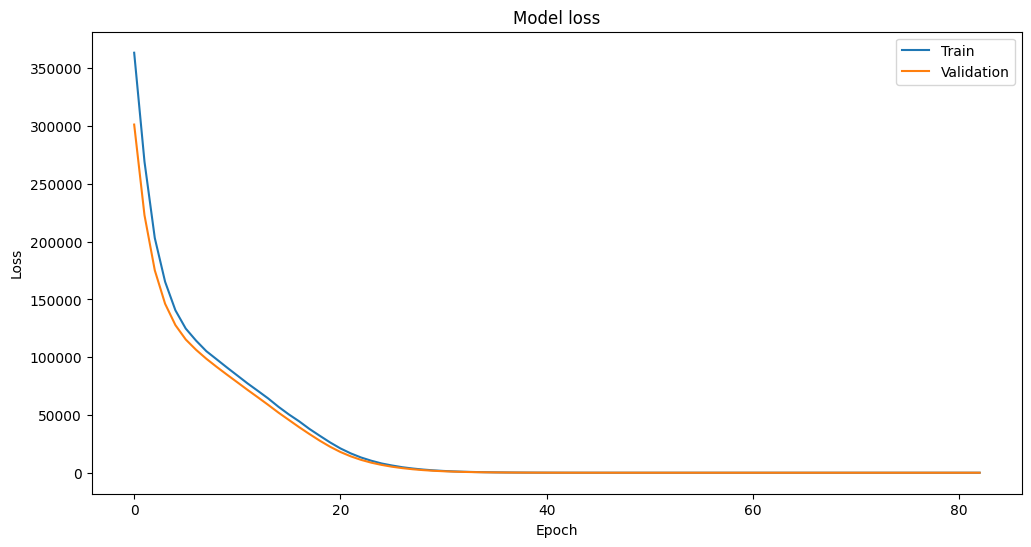

In [15]:
y_pred = model.predict(X_test).flatten()


r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'R-squared: {r2:.2f}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

2/2 [==============================] - 0s 53ms/step


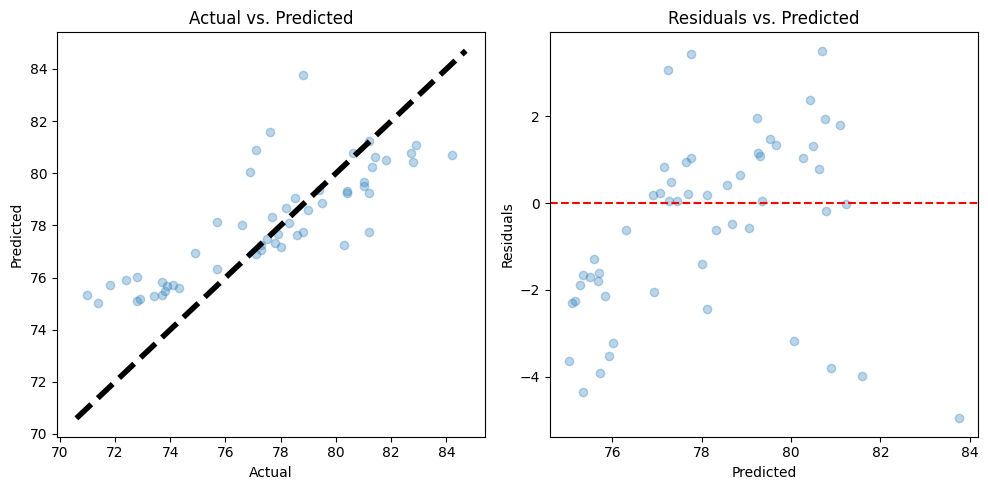

In [13]:
y_pred = model.predict(X_test).flatten()
residuals = y_test - y_pred


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


axs[0].scatter(y_test, y_pred, alpha=0.3)
axs[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
axs[0].set_xlabel('Actual')
axs[0].set_ylabel('Predicted')
axs[0].set_title('Actual vs. Predicted')


axs[1].scatter(y_pred, residuals, alpha=0.3)
axs[1].axhline(y=0, color='r', linestyle='--')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Residuals')
axs[1].set_title('Residuals vs. Predicted')

plt.tight_layout()
plt.show()